In [46]:
import os
import sys
sys.path.append('../src/')
import glob
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", 150)
pd.set_option("display.max_rows", 30)
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import seaborn as sns
sns.set_theme()
import cca_functions

In [47]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# configurations
- follow the file selection dialog:
    - select microscopy folder in first step
    - select positions of the selected folder in second step
- repeat to add more positions to the analysis
- positions selected within one iteration of the dialog will be pooled together in the following analyses

In [22]:
data_dirs, positions = cca_functions.configuration_dialog()
file_names = [os.path.split(path)[-1] for path in data_dirs]
image_folders = [[os.path.join(data_dir, pos_str, 'Images') for pos_str in pos_list] for pos_list, data_dir in zip(positions, data_dirs)]
# determine available channels based on first(!) position.
# Warn user if one or more of the channels are not available for some positions
first_pos_dir = os.path.join(data_dirs[0], positions[0][0], 'Images')
first_pos_files = os.listdir(first_pos_dir)
channels, warn = cca_functions.find_available_channels(first_pos_files, first_pos_dir)

In [48]:
first_pos_files

['19-03-2021_KCY050_SCGE_s08_acdc_output.csv',
 '19-03-2021_KCY050_SCGE_s08_acdc_output.zip',
 '19-03-2021_KCY050_SCGE_s08_align_shift.npy',
 '19-03-2021_KCY050_SCGE_s08_cca_properties_downstream.csv',
 '19-03-2021_KCY050_SCGE_s08_dataPrepROIs_coords.csv',
 '19-03-2021_KCY050_SCGE_s08_dataPrep_bkgrValues.csv',
 '19-03-2021_KCY050_SCGE_s08_delROIsInfo.npz',
 '19-03-2021_KCY050_SCGE_s08_last_tracked_i.txt',
 '19-03-2021_KCY050_SCGE_s08_mCitrine.tif',
 '19-03-2021_KCY050_SCGE_s08_mCitrine_aligned.npz',
 '19-03-2021_KCY050_SCGE_s08_metadata.csv',
 '19-03-2021_KCY050_SCGE_s08_phase_contr.tif',
 '19-03-2021_KCY050_SCGE_s08_phase_contr_aligned.npz',
 '19-03-2021_KCY050_SCGE_s08_segm.npz']

In [49]:
channels, warn

(['mCitrine', 'phase_contr'], False)

# load data and perform all needed calculations on image data

In [50]:
overall_df = cca_functions.calculate_downstream_data(
    file_names,
    image_folders,
    positions,
    channels, 
    force_recalculation=False)

Load files for TimeLapse_2D, Position_8...
Number of cells in position: 45
Number of annotated frames in position: 222
Cell Cycle property data already existing, loaded from disk...


In [51]:
overall_df.head()

,frame_i,time_seconds,Cell_ID,is_cell_dead,is_cell_excluded,x_centroid,y_centroid,editIDclicked_x,editIDclicked_y,editIDnewID,cell_cycle_stage,generation_num,relative_ID,relationship,emerg_frame_i,division_frame_i,is_history_known,corrected_assignment,cell_area_pxl,cell_vol_vox,cell_area_um2,cell_vol_fl,guiphase_contr_mean,guiphase_contr_median,guiphase_contr_min,guiphase_contr_max,guiphase_contr_sum,guiphase_contr_q25,guiphase_contr_q75,guiphase_contr_q05,guiphase_contr_q95,guiphase_contr_amount_autoBkgr,guiphase_contr_amount_dataPrepBkgr,area,convex_area,filled_area,major_axis_length,minor_axis_length,orientation,perimeter,centroid_y,centroid_x,solidity,2d_label_count,min_t,max_t,lifespan,age,frames_till_gone,elongation,mCitrine_corrected_mean,phase_contr_corrected_mean,mCitrine_corrected_amount,mCitrine_corrected_concentration,phase_contr_corrected_amount,phase_contr_corrected_concentration,max_frame_pos,file,selection_subset,position,directory
0,0,0.00,1,0,0,221,115,NaN,NaN,-1,G1,2,-1,mother,-1,-1,False,False,556.0,9369.473444,28.650124,109.595509,1108.751799,923.5,342.0,4307.0,616466.0,678.75,1343.75,481.25,2421.25,207806.0,207806.0,556,570,556,27.968666,25.347502,-1.005088,86.426407,115.347122,221.546763,0.975439,1.0,0,240,241,1,240,1.103409,711.167266,373.751799,395409.0,3607.894203,207806.0,1896.117850,221,TimeLapse_2D,0,Position_8,C:/Users/mairhoermann/Documents/phd-code/Yeast...
1,0,0.00,2,0,0,193,116,NaN,NaN,-1,S,2,3,mother,-1,-1,False,False,515.0,7969.100082,26.537435,93.215225,1048.778641,965.0,376.0,3196.0,540121.0,717.00,1295.00,491.80,1776.30,161596.0,161596.0,515,530,515,28.277938,23.198776,-1.133576,83.597980,116.400000,193.617476,0.971698,1.0,0,240,241,1,240,1.218941,759.438835,313.778641,391111.0,4195.784536,161596.0,1733.579464,221,TimeLapse_2D,0,Position_8,C:/Users/mairhoermann/Documents/phd-code/Yeast...
2,0,0.00,3,0,0,207,134,NaN,NaN,-1,S,0,2,bud,-1,-1,False,False,283.0,3340.477622,14.582707,39.073844,894.554770,692.0,304.0,3001.0,253159.0,556.00,1048.00,425.30,1962.50,45154.0,45154.0,283,291,283,20.476059,17.660182,0.856869,61.355339,134.024735,207.568905,0.972509,1.0,0,240,241,1,240,1.159448,1166.554770,159.554770,330135.0,8449.002356,45154.0,1155.606804,221,TimeLapse_2D,0,Position_8,C:/Users/mairhoermann/Documents/phd-code/Yeast...
3,1,180.43,1,0,0,221,114,NaN,NaN,-1,G1,2,-1,mother,-1,-1,False,False,556.0,9271.123057,28.650124,108.445096,1044.861511,885.0,347.0,3724.0,580943.0,677.00,1245.25,508.25,2207.75,167279.0,175063.0,556,568,556,28.210723,25.128143,-0.969097,85.597980,114.818345,221.879496,0.978873,1.0,0,240,241,2,239,1.122674,665.649281,300.861511,370101.0,3412.796097,167279.0,1542.522496,221,TimeLapse_2D,0,Position_8,C:/Users/mairhoermann/Documents/phd-code/Yeast...
4,1,180.43,2,0,0,194,115,NaN,NaN,-1,S,2,3,mother,-1,-1,False,False,517.0,8017.231491,26.640493,93.778222,1094.321083,1018.0,378.0,2977.0,565764.0,728.00,1394.00,515.40,1818.20,181116.0,188354.0,517,528,517,28.287295,23.278164,-1.087559,83.012193,115.926499,194.052224,0.979167,1.0,0,240,241,2,239,1.215186,768.746615,350.321083,397442.0,4238.105509,181116.0,1931.322601,221,TimeLapse_2D,0,Position_8,C:/Users/mairhoermann/Documents/phd-code/Yeast...


In [52]:
# Join on Cell_ID vs. relative_ID to later calculate columns like "daughter growth" or "mother-bud-signal-combined"
overall_df_rel = overall_df.copy()
overall_df = overall_df.merge(
    overall_df_rel,
    how='left',
    left_on=['frame_i', 'relative_ID', 'max_frame_pos', 'file', 'selection_subset', 'position', 'directory'],
    right_on=['frame_i', 'Cell_ID', 'max_frame_pos', 'file', 'selection_subset', 'position', 'directory'],
    suffixes = ('', '_rel')
)
for ch in channels:
    try:
        overall_df[f'{ch}_combined_amount_mother_bud'] = overall_df.apply(
            lambda x: x.loc[f'{ch}_corrected_amount']+x.loc[f'{ch}_corrected_amount_rel'] if\
            x.loc['cell_cycle_stage']=='S' and x.loc['relationship'] == 'mother' else\
            x.loc[f'{ch}_corrected_amount'],
            axis=1
        )
    except KeyError:
        continue
overall_df['combined_mother_bud_volume'] = overall_df.apply(
    lambda x: x.loc['cell_vol_fl']+x.loc['cell_vol_fl_rel'] if\
    x.loc['cell_cycle_stage']=='S' and x.loc['relationship'] == 'mother' else\
    x.loc['cell_vol_fl'],
    axis=1
)

In [53]:
overall_df.shape

(2968, 119)

In [54]:
# build dataframe grouped by phases
if 'max_t' in overall_df.columns:
    group_cols = [
        'Cell_ID', 'generation_num', 'cell_cycle_stage', 'relationship', 'position', 'file', 
        'max_frame_pos', 'selection_subset', 'max_t'
    ]
else:
    group_cols = [
        'Cell_ID', 'generation_num', 'cell_cycle_stage', 'relationship', 'position', 'file', 
        'max_frame_pos', 'selection_subset'
    ]
# group by group columns, aggregate some other columns
phase_grouped = overall_df.sort_values(
    'frame_i'
).groupby(group_cols).agg(
    # perform some calculations relating to the whole phase:
    phase_area_growth=('cell_area_um2', lambda x: x.iloc[-1]-x.iloc[0]),
    phase_volume_growth=('cell_vol_fl', lambda x: x.iloc[-1]-x.iloc[0]),
    phase_area_at_beginning=('cell_area_um2', 'first'),
    phase_volume_at_beginning=('cell_vol_fl', 'first'),
    phase_volume_at_end=('cell_vol_fl', 'last'),
    phase_daughter_area_growth=('cell_area_um2_rel', lambda x: x.iloc[-1]-x.iloc[0]),
    phase_daughter_volume_growth=('cell_vol_fl_rel', lambda x: x.iloc[-1]-x.iloc[0]),
    phase_length=('frame_i', lambda x: max(x)-min(x)),
    phase_begin = ('frame_i', min),
    phase_end = ('frame_i', max),
    phase_combined_mother_bud_volume_at_end = ('combined_mother_bud_volume','last')
).reset_index()

In [55]:
phase_grouped_flu = pd.DataFrame(columns=group_cols)
for ch in channels:
    if f'{ch}_corrected_mean' in overall_df.columns:
        flu_temp = overall_df.sort_values(
            'frame_i'
        ).groupby(group_cols).agg({
            # perform some calculations on flu data:
            f'{ch}_corrected_amount': 'first',
            f'{ch}_corrected_mean': 'first',
            f'{ch}_corrected_concentration': ['first','last']
        }).reset_index()
        # collapse multiindex into column name with aggregation as suffix
        flu_temp.columns = ['_'.join(col) if col[1]!='' else col[0] for col in flu_temp.columns.values]
        # rename columns into meaningful names
        flu_temp = flu_temp.rename({
            f'{ch}_corrected_amount_first': f'phase_{ch}_corrected_amount_at_beginning',
            f'{ch}_corrected_mean_first': f'phase_{ch}_corrected_mean_at_beginning',
            f'{ch}_corrected_concentration_first': f'phase_{ch}_corrected_concentration_at_beginning',
            f'{ch}_corrected_concentration_last': f'phase_{ch}_corrected_concentration_at_end'
        }, axis=1)
        phase_grouped_flu = phase_grouped_flu.merge(flu_temp, how='right', on=group_cols, suffixes=('',''))

In [56]:
phase_grouped_flu

,Cell_ID,generation_num,cell_cycle_stage,relationship,position,file,max_frame_pos,selection_subset,max_t,phase_mCitrine_corrected_amount_at_beginning,phase_mCitrine_corrected_mean_at_beginning,phase_mCitrine_corrected_concentration_at_beginning,phase_mCitrine_corrected_concentration_at_end,phase_phase_contr_corrected_amount_at_beginning,phase_phase_contr_corrected_mean_at_beginning,phase_phase_contr_corrected_concentration_at_beginning,phase_phase_contr_corrected_concentration_at_end
0,1,2,G1,mother,Position_8,TimeLapse_2D,221,0,240,395409.0,711.167266,3607.894203,3137.986569,207806.0,373.751799,1896.117850,1595.535802
1,1,2,S,mother,Position_8,TimeLapse_2D,221,0,240,392779.0,636.594814,3109.945346,2969.779308,239796.0,388.648298,1898.656634,1749.242633
2,1,3,G1,mother,Position_8,TimeLapse_2D,221,0,240,395624.0,639.134087,3037.017928,2802.751351,209153.0,337.888530,1605.568445,1934.565282
3,1,3,S,mother,Position_8,TimeLapse_2D,221,0,240,439797.0,619.432394,2893.735190,2488.746065,281431.0,396.381690,1851.733387,1864.205210
4,1,4,G1,mother,Position_8,TimeLapse_2D,221,0,240,344019.0,542.616719,2681.968098,2354.903934,217189.0,342.569401,1693.202902,1598.945220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,43,2,G1,mother,Position_8,TimeLapse_2D,221,0,240,355203.0,691.056420,3809.474120,5557.197668,195851.0,381.033074,2100.458937,1333.362848
141,44,2,G1,mother,Position_8,TimeLapse_2D,221,0,240,2467.0,24.919192,290.466562,265.783963,1939.0,19.585859,228.299418,810.945148
142,45,0,S,bud,Position_8,TimeLapse_2D,221,0,240,5887.0,90.569231,1357.513320,724.796293,23450.0,360.769231,5407.454961,4318.154833
143,46,0,S,bud,Position_8,TimeLapse_2D,221,0,221,3492.0,65.886792,1255.135896,1255.135896,28773.0,542.886792,10341.931600,10341.931600


In [57]:
# detect complete cell cycle phases and complete cell cycles
temp = np.logical_and(
    phase_grouped.phase_begin > 0,
    phase_grouped.phase_end < phase_grouped.max_frame_pos
)
# this or is for disappearing cells
if 'max_t' in overall_df.columns:
    complete_phase_indices = np.logical_and(
        temp,
        phase_grouped.phase_end < phase_grouped.max_t
    )
else:
    complete_phase_indices = temp
phase_grouped['complete_phase'] = complete_phase_indices.astype(int)
no_of_compl_phases_per_cycle = phase_grouped.groupby(
    ['Cell_ID', 'generation_num', 'position', 'file']
)['complete_phase'].transform('sum')
complete_cycle_indices = no_of_compl_phases_per_cycle == 2
phase_grouped['complete_cycle'] = complete_cycle_indices.astype(int)
# join phase-grouped data with 
phase_grouped = phase_grouped.merge(phase_grouped_flu, how='left', on=group_cols, suffixes=('',''))
# append phase-grouped data to overall_df
overall_df = overall_df.merge(
    phase_grouped,
    how='left',
    on=group_cols
)

In [60]:
phase_grouped.head()

,Cell_ID,generation_num,cell_cycle_stage,relationship,position,file,max_frame_pos,selection_subset,max_t,phase_area_growth,phase_volume_growth,phase_area_at_beginning,phase_volume_at_beginning,phase_volume_at_end,phase_daughter_area_growth,phase_daughter_volume_growth,phase_length,phase_begin,phase_end,phase_combined_mother_bud_volume_at_end,complete_phase,complete_cycle,phase_mCitrine_corrected_amount_at_beginning,phase_mCitrine_corrected_mean_at_beginning,phase_mCitrine_corrected_concentration_at_beginning,phase_mCitrine_corrected_concentration_at_end,phase_phase_contr_corrected_amount_at_beginning,phase_phase_contr_corrected_mean_at_beginning,phase_phase_contr_corrected_concentration_at_beginning,phase_phase_contr_corrected_concentration_at_end
0,1,2,G1,mother,Position_8,TimeLapse_2D,221,0,240,2.370334,10.683209,28.650124,109.595509,120.278717,NaN,NaN,8,0,8,120.278717,0,0,395409.0,711.167266,3607.894203,3137.986569,207806.0,373.751799,1896.117850,1595.535802
1,1,2,S,mother,Position_8,TimeLapse_2D,221,0,240,-0.463761,2.021245,31.793393,126.297718,128.318963,19.993252,64.376994,30,9,39,193.136646,1,0,392779.0,636.594814,3109.945346,2969.779308,239796.0,388.648298,1898.656634,1749.242633
2,1,3,G1,mother,Position_8,TimeLapse_2D,221,0,240,4.483023,19.586563,31.896451,130.267259,149.853821,NaN,NaN,10,40,50,149.853821,1,1,395624.0,639.134087,3037.017928,2802.751351,209153.0,337.888530,1605.568445,1934.565282
3,1,3,S,mother,Position_8,TimeLapse_2D,221,0,240,-2.782566,-15.107510,36.585590,151.982462,136.874953,16.231635,47.288734,22,51,73,184.939068,1,1,439797.0,619.432394,2893.735190,2488.746065,281431.0,396.381690,1851.733387,1864.205210
4,1,4,G1,mother,Position_8,TimeLapse_2D,221,0,240,3.710088,22.692170,32.669386,128.271101,150.963271,0.875993,1.353150,7,74,81,150.963271,1,1,344019.0,542.616719,2681.968098,2354.903934,217189.0,342.569401,1693.202902,1598.945220


# ACDC paper figures

## Flurescence Signal over time (centered on bud emergence)

In [61]:
# some configurations
# frame interval of video
frame_interval_minutes = 3
# quantiles of complete cell cycles (wrt phase lengths) to exclude from analysis 
# (keep this for potential later use)
down_q, upper_q = 0, 1
# minimum number of cell cycles contributing to the mean+CI curve:
min_no_of_ccs = 10
# determine if you want to split the plot by generation
split_by_gen = True
# wether to scale to 0/1 or not
scale_data = True

In [62]:
# select needed cols from overall_df to not end up with too many columns
needed_cols = [
    'selection_subset', 'position', 'Cell_ID', 'cell_cycle_stage', 'generation_num', 'frame_i',
    'mCitrine_corrected_amount', 'mCitrine_corrected_amount_rel', 
    'file', 'relationship', 'relative_ID', 'phase_length', 'phase_begin', 'gui_mCitrine_amount_autoBkgr'
]
filter_idx = np.logical_and(overall_df['complete_cycle'] == 1, overall_df.selection_subset==0)
plot_data6 = overall_df.loc[filter_idx, needed_cols].copy()
# calculate the time the cell already spent in the current frame at the current timepoint
plot_data6['frames_in_phase'] = plot_data6['frame_i'] - plot_data6['phase_begin'] + 1
# calculate the time to the next (for G1 cells) and from the last (for S cells) G1/S transition  
plot_data6['centered_frames_in_phase'] = plot_data6.apply(
    lambda x: x.loc['frames_in_phase'] if\
    x.loc['cell_cycle_stage']=='S' else\
    x.loc['frames_in_phase']-1-x.loc['phase_length'],
    axis=1
)
# calculate combined signal and the "Pool, Phase ID" for the legend
# plot_data6 at this point only contains relationship==mother, 
# as generation_num==0 and relationship==bud are filtered out (incomplete cycle, cycles start with G1)
plot_data6['Combined Signal M&B'] = plot_data6.apply(
    lambda x: x.loc['mCitrine_corrected_amount']+x.loc['mCitrine_corrected_amount_rel'] if\
    x.loc['cell_cycle_stage']=='S' and x.loc['relationship'] == 'mother' else\
    x.loc['mCitrine_corrected_amount'],
    axis=1
)
plot_data6['Bud Signal'] = plot_data6.apply(
    lambda x: x.loc['mCitrine_corrected_amount_rel'] if\
    x.loc['cell_cycle_stage']=='S' and x.loc['relationship'] == 'mother' else 0,
    axis=1
)
if scale_data:
    maximum = max(
        plot_data6['Combined Signal M&B'].max(), 
        plot_data6['Bud Signal'].max()
    )
    plot_data6['Combined Signal M&B'] /= maximum
    plot_data6['Bud Signal'] /= maximum

plot_data6['min_centered_frames'] = plot_data6.groupby(
    ['position', 'file', 'Cell_ID', 'generation_num']
)['centered_frames_in_phase'].transform(
    'min'
)
plot_data6['max_centered_frames'] = plot_data6.groupby(
    ['position', 'file', 'Cell_ID', 'generation_num']
)['centered_frames_in_phase'].transform(
    'max'
)

min_and_max = plot_data6.groupby(
    ['Cell_ID', 'generation_num', 'position', 'file']
).agg(
    min_centered = ('min_centered_frames', 'first'),
    max_centered = ('max_centered_frames', 'first')
).reset_index()

min_val, max_val = np.quantile(
    min_and_max.min_centered, down_q
) * frame_interval_minutes, np.quantile(
    min_and_max.max_centered, upper_q
) * frame_interval_minutes

KeyError: "['gui_mCitrine_amount_autoBkgr'] not in index"

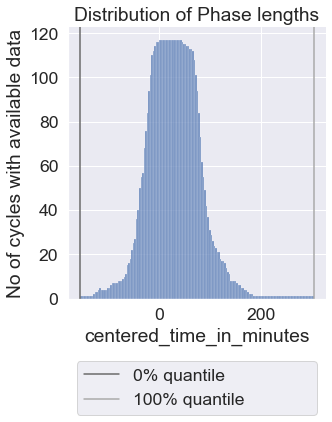

(5262, 21)
(5262, 22)
(4913, 23)


In [56]:
# plot histogram of min and max centered times
plot_data6['centered_time_in_minutes'] = plot_data6.centered_frames_in_phase * frame_interval_minutes
sns.displot(
    height=5,
    data=plot_data6,
    x='centered_time_in_minutes',
    bins=len(plot_data6.centered_frames_in_phase.unique())
)
plt.title('Distribution of Phase lengths')
plt.axvline(x=min_val, color='dimgray', label=f'{down_q*100}% quantile')
plt.axvline(x=max_val, color='darkgray', label=f'{upper_q*100}% quantile')
plt.legend(mode='expand', bbox_to_anchor=(0., -0.3, 1., 0.102))
plt.ylabel('No of cycles with available data')
plt.show()

# selection of ccs by percentiles not in use if min_q and max_q are 0 and 1 respectively
selection_indices = np.logical_and(
    plot_data6.min_centered_frames*frame_interval_minutes>=min_val, 
    plot_data6.max_centered_frames*frame_interval_minutes<=max_val
)
print(plot_data6.shape)
plot_data6 = plot_data6[selection_indices]

# filter for number of contributing cell cycles


# group dataframe to calculate sample sizes per generation
standard_grouped = plot_data6.groupby(
    ['position', 'file', 'Cell_ID', 'generation_num']
).agg('count').reset_index()
plot_data6['Generation'] = plot_data6.apply(
    lambda x: f'1st ($n_1$={len(standard_grouped[standard_grouped.generation_num==1])})' if\
    x.loc['generation_num']==1 else f'2+ ($n_2$={len(standard_grouped[standard_grouped.generation_num>1])})',
    axis=1
)
print(plot_data6.shape)
if split_by_gen:
    g_cols = ['centered_frames_in_phase', 'Generation']
else:
    g_cols = 'centered_frames_in_phase'
plot_data6['contributing_ccs_at_time'] = plot_data6.groupby(g_cols).transform('count')['selection_subset']
plot_data6 = plot_data6[plot_data6.contributing_ccs_at_time >= min_no_of_ccs]
print(plot_data6.shape)

# finally prepare data for plot (use melt for multiple lines)
sample_size = len(standard_grouped)
avg_cell_cycle_length = round(standard_grouped.loc[:,'centered_time_in_minutes'].mean())*frame_interval_minutes
cols_to_plot = ['Bud Signal', 'Combined Signal M&B']
index_cols = [col for col in plot_data6.columns if col not in cols_to_plot]
plot_data6_melted = pd.melt(
    plot_data6, index_cols, var_name='Method of Calculation'
).sort_values('Method of Calculation')

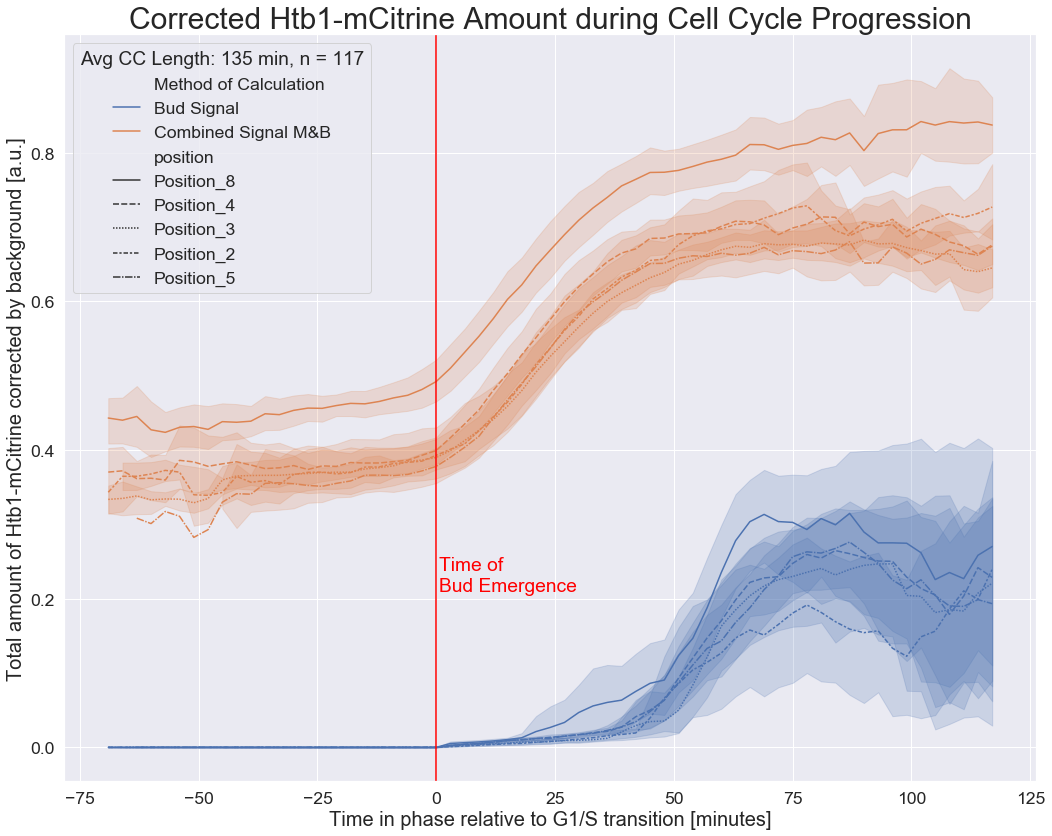

In [59]:
# plot the data, comment out "style" argument to not make difference between generations
sns.set_theme(style="darkgrid", font_scale=1.6)
f, ax = plt.subplots(figsize=(15, 12))
if split_by_gen:
    style='Generation'
else:
    style=None
ax = sns.lineplot(
    data=plot_data6_melted,#.sort_values('Pool, Phase'),
    x="centered_time_in_minutes", 
    y="value",
    hue='Method of Calculation',
    #hue='position',
    #style=style,
    style='position',
    ci=95
)
ax.axvline(x=0, color='red')#, label='Time of Bud Emergence')
ax.text(
    0.5, 0.21, "Time of \nBud Emergence", horizontalalignment='left', 
    size='medium', color='red', weight='normal'
)
#ax.axvline(x=min_val, color='darkgray', label=f'{down_q*100}%-quantile (G1 phase length)')
#ax.axvline(x=max_val, color='dimgray', label=f'{upper_q*100}%-quantile (S phase length)')
ax.legend(
    title=f'Avg CC Length: {avg_cell_cycle_length} min, n = {sample_size}', 
    fancybox=True,
    labelspacing=0.5,
    handlelength=1.5,
    loc = 'upper left'
)
#plt.setp(ax.get_legend().get_title(), fontsize='20') 
ax.set_ylabel("Total amount of Htb1-mCitrine corrected by background [a.u.]", fontsize=20)
ax.set_xlabel("Time in phase relative to G1/S transition [minutes]", fontsize=20)
ax.set_title("Corrected Htb1-mCitrine Amount during Cell Cycle Progression", fontsize=30)
plt.tight_layout()
"""
plt.savefig(
    os.path.join('..', 'figures', 'mCitrine_over_time_by_gen_v4.pdf'),
    dpi=300
)
"""
plt.show()

## Volume at birth and division vs. mCitrine amount at birth (single cell) and division (combined)

In [9]:
# obtain table where one cell cycle is represented by one row: 
# first set of columns (like phase_length, growth...) for G1, second set of cols for S
needed_cols = [
    'Cell_ID', 'generation_num', 'position', 'file', 'cell_cycle_stage', 'selection_subset', 
    'phase_volume_at_beginning', 'phase_volume_at_end', 'phase_mCitrine_amount_at_beginning',
    'phase_mCitrine_amount_comb_end', 'phase_volume_at_end_combined'
]
plot_data4 = phase_grouped.loc[phase_grouped.complete_cycle==1, needed_cols]
scale_data = False

In [10]:
plot_data4['relevant_volume'] = plot_data4.apply(
    lambda x: x.loc['phase_volume_at_beginning'] if\
    x.loc['cell_cycle_stage']=='G1' else\
    x.loc['phase_volume_at_end_combined'],
    axis=1
)
plot_data4['relevant_amount'] = plot_data4.apply(
    lambda x: x.loc['phase_mCitrine_amount_at_beginning'] if\
    x.loc['cell_cycle_stage']=='G1' else\
    x.loc['phase_mCitrine_amount_comb_end'],
    axis=1
)
# defining a function to generate entries for the figure legend 
# (assuming that selection_subset>0 is the autofluorescence control of the experiment)
def calc_legend_entry(x):
    if x.loc['selection_subset'] == 0:
        if x.loc['cell_cycle_stage']=='G1':
            return 'Single cell at birth'
        else:
            return 'Combined mother&bud at cytokinesis'
    else:
        if x.loc['cell_cycle_stage']=='G1':
            return 'Af control, single cell at birth'
        else:
            return 'Af control, combined mother&bud at cytokinesis'
        
plot_data4['Kind of Measurement'] = plot_data4.apply(
    lambda x: 'Single Cell in G1 (Frame after Cytokinesis)' if\
    x.loc['cell_cycle_stage']=='G1' else\
    'Combined Mother & Bud in S (Frame before Cytokinesis)',
    axis=1
)
plot_data4['Kind of Measurement new'] = plot_data4.apply(
    calc_legend_entry,
    axis=1
)
plot_data4['Generation'] = plot_data4.apply(
    lambda x: f'1st ($n_1$={int(len(plot_data4[plot_data4.generation_num==1])/2)})' if\
    x.loc['generation_num']==1 else f'2+ ($n_2$={int(len(plot_data4[plot_data4.generation_num>1])/2)})',
    axis=1
)
if scale_data:
    maximum = plot_data4['relevant_amount'].max()
    plot_data4['relevant_amount'] /= maximum
sample_size = len(plot_data4)


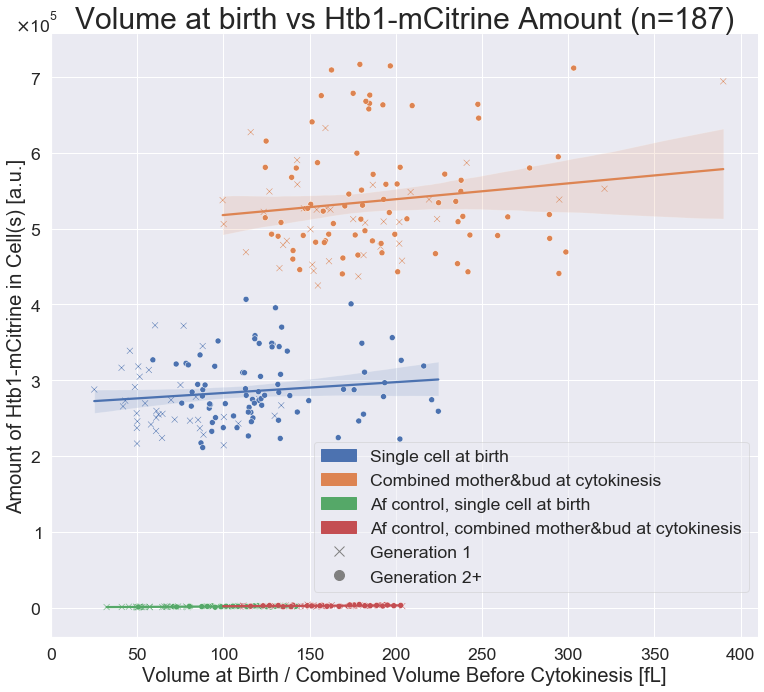

sample size flu-control: 70
sample size tagged strain: 117


In [56]:
#plot_data4 = plot_data4[plot_data4.selection_subset==1]
sns.set_theme(style="darkgrid", font_scale=1.6)
# Initialize the figure
sns.lmplot(
    x="relevant_volume", 
    y="relevant_amount", 
    data=plot_data4.sort_values(
        'Kind of Measurement new', ascending=False
    ),
    hue="Kind of Measurement new",
    legend=False,
    #style="generation_num",
    #row="selection_subset",
    #sharex=False,
    height=10,
    aspect=1.1,
    scatter=False
)

sns.scatterplot(
    x="relevant_volume", 
    y="relevant_amount", 
    data=plot_data4[plot_data4.generation_num==1].sort_values(
        'Kind of Measurement new', ascending=False
    ),
    hue="Kind of Measurement new",
    legend=False,
    marker='x'
)

sns.scatterplot(
    x="relevant_volume", 
    y="relevant_amount", 
    data=plot_data4[plot_data4.generation_num>1].sort_values(
        'Kind of Measurement new', ascending=False
    ),
    hue="Kind of Measurement new",
    legend=False,
    marker='o'
)

#g._legend.set_title('Kind of Measurement')
ax = plt.gca()
#ax.set(yscale="log2")
#ax.set_yscale('log', basey=2)
#ax.set_xscale('log', basex=10)
labels = [
    'Single cell at birth',
    'Combined mother&bud at cytokinesis',
    'Af control, single cell at birth',
    'Af control, combined mother&bud at cytokinesis',
    'Generation 1',
    'Generation 2+'
]
handles = [
    mpatches.Patch(color=sns.color_palette()[0]),
    mpatches.Patch(color=sns.color_palette()[1]),
    mpatches.Patch(color=sns.color_palette()[2]),
    mpatches.Patch(color=sns.color_palette()[3]),
    mlines.Line2D([], [], color='gray', marker='x', linestyle='None',
                          markersize=10),
    mlines.Line2D([], [], color='gray', marker='o', linestyle='None',
                          markersize=10)
]
ax.legend(
    handles=handles,
    labels=labels, 
    loc='center right',
    bbox_to_anchor = (1,0.2),
    framealpha=0.5
)
ax.set_ylabel("Amount of Htb1-mCitrine in Cell(s) [a.u.]", fontsize=20)
ax.set_xlabel("Volume at Birth / Combined Volume Before Cytokinesis [fL]", fontsize=20)
ax.set_title(f"Volume at birth vs Htb1-mCitrine Amount (n={int(sample_size/2)})", fontsize=30)
# format y-axis
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0), useMathText=True)
ax.get_yaxis().get_offset_text().set_position((-0.05,0))
# format x-axis
ax.set_xlim(0, plot_data4.relevant_volume.max()+20)
plt.tight_layout()
"""
plt.savefig(
    os.path.join('..', 'figures', 'mCitrine_at_birth_and_cytokinesis_v5.pdf'),
    dpi=300
)
"""
plt.show()
print(f'sample size flu-control: {len(plot_data4[plot_data4.selection_subset==1])//2}')
print(f'sample size tagged strain: {len(plot_data4[plot_data4.selection_subset==0])//2}')

# Plot gallery - timelapse data

## (Volume) growth in G1 vs. mother+daughter growth in S (1st generation)

In [ ]:
# obtain table where one cell cycle is represented by one row: 
# first set of columns (like phase_length, growth...) for G1, second set of cols for S
complete_cc_data = phase_grouped[phase_grouped.all_complete==1]
s_data = complete_cc_data[complete_cc_data.cell_cycle_stage=="S"]
g1_data = complete_cc_data[complete_cc_data.cell_cycle_stage=="G1"]
plot_data2 = g1_data.merge(s_data, on=['Cell_ID', 'generation_num', 'position'], how='inner')
plot_data2 = plot_data2[plot_data2.generation_num==1]
plot_data2['combined_motherbud_growth'] = plot_data2['growth_in_phase_y'] + plot_data2['daughter_area_growth_y']
plot_data2['combined_motherbud_vol_growth'] = plot_data2['volume_growth_in_phase_y'] + plot_data2['daughter_volume_growth_y']

In [ ]:
sns.set_theme(style="darkgrid", font_scale=2)
# Initialize the figure
g = sns.lmplot(x="growth_in_phase_x", y="combined_motherbud_growth", data=plot_data2,
    hue="selection_subset_x", height=10)
g._legend.set_title('Position Pool')
ax = plt.gca()
ax.set_ylabel("Combined Mother+Bud S growth [pixel area]", fontsize=20)
ax.set_xlabel("G1 growth [pixel area]", fontsize=20)
ax.set_title("G1 growth vs. mother+daughter cell S growth (area)", fontsize=30)
plt.show()

In [ ]:
sns.set_theme(style="darkgrid", font_scale=2)
# Initialize the figure
g = sns.lmplot(x="volume_growth_in_phase_x", y="combined_motherbud_vol_growth", data=plot_data2,
    hue="selection_subset_x", height=10)
g._legend.set_title('Position Pool')
ax = plt.gca()
ax.set_ylabel("Combined Mother+Bud S volume growth [fl]", fontsize=20)
ax.set_xlabel("G1 volume growth [fl]", fontsize=20)
ax.set_title("G1 growth vs. mother+daughter cell S growth (Volume)", fontsize=30)
plt.show()

## Area and Volume at birth vs. G1 duration (1st generation)

In [107]:
# obtain table where one cell cycle is represented by one row: 
# first set of columns (like phase_length, growth...) for G1, second set of cols for S
plot_data3 = phase_grouped[phase_grouped.cell_cycle_stage=="G1"]
plot_data3 = plot_data3[plot_data3.incomplete_phase==0]
plot_data3 = plot_data3[plot_data3.generation_num==1]

sns.set_theme(style="darkgrid", font_scale=2)
# Initialize the figure
g = sns.lmplot(x="area_at_beginning", y="phase_length", data=plot_data3,
    hue="selection_subset", height=10)
g._legend.set_title('Position Pool')
ax = plt.gca()
ax.set_ylabel("Duration of first G1 phase [frames]", fontsize=20)
ax.set_xlabel("Area at birth (first cytokinesis)", fontsize=20)
ax.set_title("Area at birth vs G1 duration (1st generation)", fontsize=30)
plt.show()

KeyError: "['selection_subset', 'area_at_beginning'] not in index"

In [108]:
sns.set_theme(style="darkgrid", font_scale=2)
# Initialize the figure
g = sns.lmplot(x="volume_at_beginning", y="phase_length", data=plot_data3,
    hue="selection_subset", height=10)
g._legend.set_title('Position Pool')
ax = plt.gca()
ax.set_ylabel("Duration of first G1 phase [frames]", fontsize=20)
ax.set_xlabel("Volume at birth (first cytokinesis) [fL]", fontsize=20)
ax.set_title("Volume at birth vs G1 duration (1st generation)", fontsize=30)
plt.show()

KeyError: "['selection_subset', 'volume_at_beginning'] not in index"

## Area and Volume at birth vs. mCitrine concentration at birth (1st generation)

In [ ]:
# obtain table where one cell cycle is represented by one row: 
# first set of columns (like phase_length, growth...) for G1, second set of cols for S
plot_data4 = phase_grouped[phase_grouped.cell_cycle_stage=="G1"]
plot_data4 = plot_data4[plot_data4.incomplete_phase==0]
plot_data4 = plot_data4[plot_data4.generation_num==1]

sns.set_theme(style="darkgrid", font_scale=2)
# Initialize the figure
g = sns.lmplot(x="area_at_beginning", y="mCitrine_concentration_at_beginning", data=plot_data4,
    hue="selection_subset", height=10, )
g._legend.set_title('Position Pool')
g.set(yscale="log")
ax = plt.gca()
ax.set_ylabel("mCitrine concentration in cell [a.u.]", fontsize=20)
ax.set_xlabel("Area at birth (first cytokinesis)", fontsize=20)
ax.set_title("Area at birth vs mCitrine concentration (1st generation)", fontsize=30)
plt.show()

In [ ]:
sns.set_theme(style="darkgrid", font_scale=2)
# Initialize the figure
g = sns.lmplot(x="volume_at_beginning", y="mCitrine_concentration_at_beginning", data=plot_data4,
    hue="selection_subset", height=10, )
g._legend.set_title('Position Pool')
ax = plt.gca()
ax.set_yscale("log")
ax.set_ylabel("mCitrine concentration in cell [a.u.]", fontsize=20)
ax.set_xlabel("Volume at birth (first cytokinesis)", fontsize=20)
ax.set_title("Volume at birth vs mCitrine concentration (1st generation)", fontsize=30)
plt.show()

## G1 vs. S duration (1st generation)

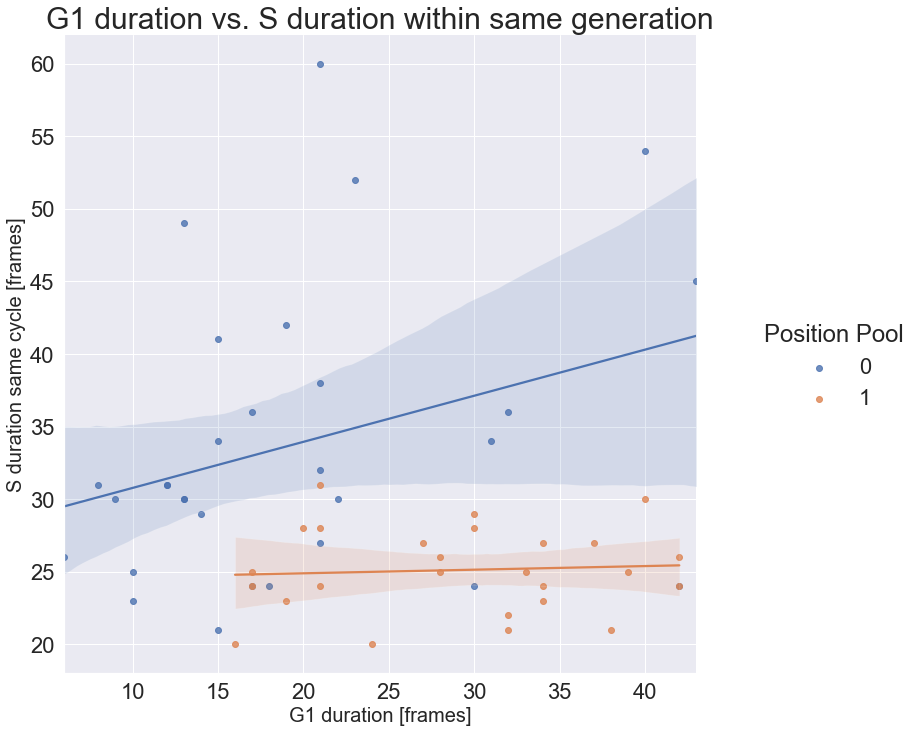

In [31]:
# obtain table where one cell cycle is represented by one row: 
# first set of columns (like phase_length, growth...) for G1, second set of cols for S
complete_cc_data = phase_grouped[phase_grouped.all_complete==1]
s_data = complete_cc_data[complete_cc_data.cell_cycle_stage=="S"]
g1_data = complete_cc_data[complete_cc_data.cell_cycle_stage=="G1"]
plot_data1 = g1_data.merge(s_data, on=['Cell_ID', 'generation_num', 'position', 'file'], how='inner')
plot_data1 = plot_data1[plot_data1.generation_num==1]

sns.set_theme(style="darkgrid", font_scale=2)
# Initialize the figure
g = sns.lmplot(x="phase_length_x", y="phase_length_y", data=plot_data1,
    hue="selection_subset_x", height=10)
g._legend.set_title('Position Pool')
ax = plt.gca()
ax.set_ylabel("S duration same cycle [frames]", fontsize=20)
ax.set_xlabel("G1 duration [frames]", fontsize=20)
ax.set_title("G1 duration vs. S duration within same generation", fontsize=30)
plt.show()

# plot gallery - zstack data

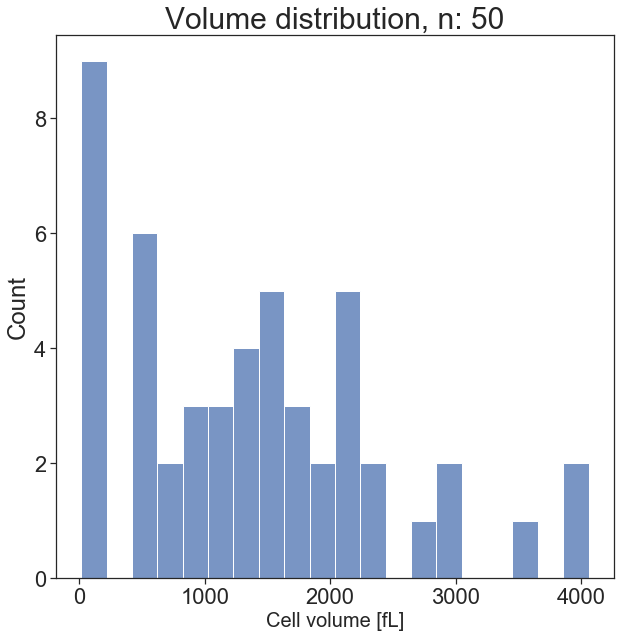

In [76]:
plot_data1 = phase_grouped
sns.set_theme(style="ticks", font_scale=2)

# Initialize the figure
plt.figure(figsize=(10,10))
sns.histplot(x='phase_volume_at_end', data=plot_data1,
            palette="vlag", bins=20)

# Tweak the visual presentation
ax = plt.gca()
ax.set_xlabel("Cell volume [fL]", fontsize=20)
ax.set_title(f"Volume distribution, n: {plot_data1.shape[0]}", fontsize=30)
#sns.despine(trim=True, left=True)
plt.show()

# backup